In [ ]:
!pip install optuna==3.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.2 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd

eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df = df[['Close']]

df.reset_index(inplace=True)
df.rename(columns={"Date": "ds", "Close": "y"}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.tz_localize(None)
df['y'] = df['y'].astype('float32')


df.fillna(method='ffill', inplace=True)

df.head()

<ipython-input-1-ce2685d011af>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,ds,y
0,1993-08-12,2.754305
1,1993-08-13,2.670113
2,1993-08-16,2.694169
3,1993-08-17,2.706196
4,1993-08-18,2.706196


In [ ]:
df.shape

(8009, 2)

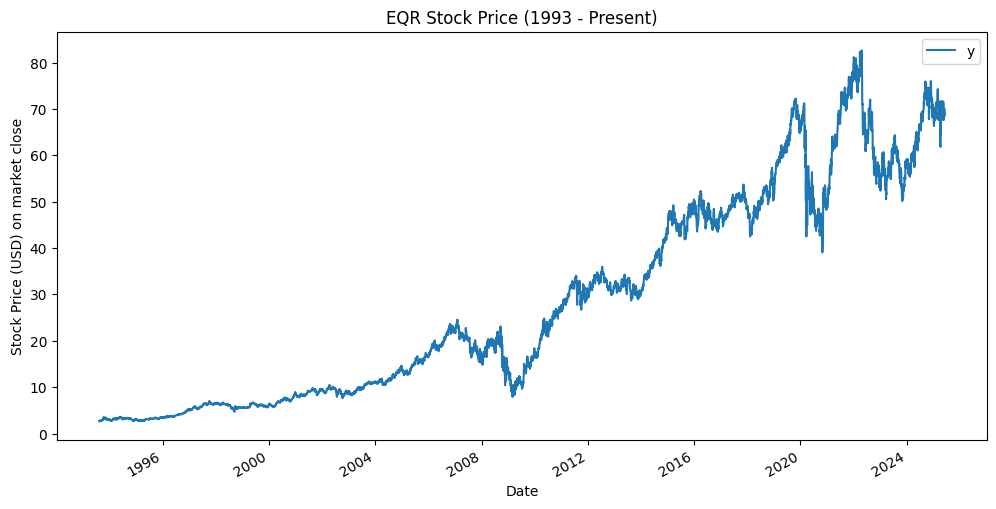

In [ ]:
from matplotlib import pyplot as plt

df.plot(x='ds', y='y', title='EQR Stock Price (1993 - Present)', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Stock Price (USD) on market close')
plt.show()

In [ ]:
import joblib
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        }

        model = Prophet(**params)
        model.fit(df)

        df_cv = cross_validation(
            model,
            initial='730 days',
            period='180 days',
            horizon='365 days'
        )

        if df_cv.empty:
            return float('inf')

        df_p = performance_metrics(df_cv, metrics=['rmse'])
        rmse = df_p['rmse'].mean()

        return rmse

def save_best_model_callback(study, trial):
        if study.best_trial.value == trial.value:
            print(f"Trial {trial.number} achieved a new best value: {trial.value}. Saving model...")
            try:
                best_params = trial.params
                best_model = Prophet(**best_params)
                best_model.fit(df)

                joblib.dump(best_model, 'best_prophet_model_callback.pkl')
                print("Model saved.")
            except Exception as e:
                print(f"Error saving model: {e}")

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, callbacks=[save_best_model_callback])

print("Optimization finished.")
print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

[I 2025-06-06 09:15:42,461] A new study created in memory with name: no-name-cdf95f1b-be88-4918-8e4c-b7112743ace6
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/a21uwtvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/hvcbz7tv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43049', 'data', 'file=/tmp/tmp4sjnqf7g/a21uwtvr.json', 'init=/tmp/tmp4sjnqf7g/hvcbz7tv.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modele97ge2wq/prophet_model-20250606091545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:15:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:15:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forec

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/chmnd7xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/mbdw7447.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26184', 'data', 'file=/tmp/tmp4sjnqf7g/chmnd7xy.json', 'init=/tmp/tmp4sjnqf7g/mbdw7447.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_model81ztrb8i/prophet_model-20250606091556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:15:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/alvpshau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/u23ug14x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Trial 0 achieved a new best value: 7.0217308996764345. Saving model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/8g0x5ndn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92491', 'data', 'file=/tmp/tmp4sjnqf7g/2j76xh2n.json', 'init=/tmp/tmp4sjnqf7g/8g0x5ndn.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelle3tvbw7/prophet_model-20250606092109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/nrnd_s7q.json


Model saved.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/54kusozt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47073', 'data', 'file=/tmp/tmp4sjnqf7g/nrnd_s7q.json', 'init=/tmp/tmp4sjnqf7g/54kusozt.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelzoi8anta/prophet_model-20250606092117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 1995-11-05 00:00:00 and 2024-06-05 00:00:00


  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/17mknv04.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/xrtctfqg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35912', 'data', 'file=/tmp/tmp4sjnqf7g/17mknv04.json', 'init=/tmp/tmp4sjnqf7g/xrtctfqg.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_model4est4_36/prophet_model-20250606092122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/g8q5c8ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/sjm4gt18.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Trial 1 achieved a new best value: 6.869385652609353. Saving model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/1w3hkz40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82854', 'data', 'file=/tmp/tmp4sjnqf7g/_cdmx2ba.json', 'init=/tmp/tmp4sjnqf7g/1w3hkz40.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelra8yx6fm/prophet_model-20250606092338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/6ggzjyr5.json


Model saved.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/o6bhw622.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77992', 'data', 'file=/tmp/tmp4sjnqf7g/6ggzjyr5.json', 'init=/tmp/tmp4sjnqf7g/o6bhw622.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelpe4o20kr/prophet_model-20250606092342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 1995-11-05 00:00:00 and 2024-06-05 00:00:00


  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/m_m1y138.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/ktslnjbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37209', 'data', 'file=/tmp/tmp4sjnqf7g/m_m1y138.json', 'init=/tmp/tmp4sjnqf7g/ktslnjbw.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelps9dvtiv/prophet_model-20250606092357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/q8s510f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/w4wo7354.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/o9gn3zg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/e7sm4gjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80229', 'data', 'file=/tmp/tmp4sjnqf7g/o9gn3zg3.json', 'init=/tmp/tmp4sjnqf7g/e7sm4gjm.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelt_ogr4h6/prophet_model-20250606093005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/g9vl5oje.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/2qcqfo5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/lkf3vjbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/1ttlfuyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27328', 'data', 'file=/tmp/tmp4sjnqf7g/lkf3vjbm.json', 'init=/tmp/tmp4sjnqf7g/1ttlfuyy.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelq6s8no6i/prophet_model-20250606093307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/onrsn639.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/ofc49cjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/6wxoy6r9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/1sbxl_dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1441', 'data', 'file=/tmp/tmp4sjnqf7g/6wxoy6r9.json', 'init=/tmp/tmp4sjnqf7g/1sbxl_dy.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modellku61nmb/prophet_model-20250606093621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:36:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:36:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/lkqinnfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/aqbld1xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/cocytszc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/zq5y72ns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32203', 'data', 'file=/tmp/tmp4sjnqf7g/cocytszc.json', 'init=/tmp/tmp4sjnqf7g/zq5y72ns.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelqhftks6l/prophet_model-20250606093930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/dq1gcqjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/hciej4wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/28812sm4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/s0ylw9pq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73480', 'data', 'file=/tmp/tmp4sjnqf7g/28812sm4.json', 'init=/tmp/tmp4sjnqf7g/s0ylw9pq.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_model161mn_h7/prophet_model-20250606094228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/a84riyus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/jtfh_47x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/r0qy_q42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/dbw34qmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84587', 'data', 'file=/tmp/tmp4sjnqf7g/r0qy_q42.json', 'init=/tmp/tmp4sjnqf7g/dbw34qmy.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modeltf7_k5wz/prophet_model-20250606094542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:45:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/w1ab_tol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/tc9fyowj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/59 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/aewl96tx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/27tffmt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12488', 'data', 'file=/tmp/tmp4sjnqf7g/aewl96tx.json', 'init=/tmp/tmp4sjnqf7g/27tffmt6.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modeltyn9tro_/prophet_model-20250606095031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/k1_odsi3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/1bm0gg96.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

KeyboardInterrupt: 

In [ ]:
model_file_path = 'best_prophet_model_callback.pkl'

model = joblib.load(model_file_path)

In [ ]:
changepoint_prior_scale = model.changepoint_prior_scale
seasonality_prior_scale = model.seasonality_prior_scale
holidays_prior_scale = model.holidays_prior_scale
seasonality_mode = model.seasonality_mode
growth = model.growth

print("\nParameters of the loaded model:")
print(f"  changepoint_prior_scale: {changepoint_prior_scale}")
print(f"  seasonality_prior_scale: {seasonality_prior_scale}")
print(f"  holidays_prior_scale: {holidays_prior_scale}")
print(f"  seasonality_mode: {seasonality_mode}")
print(f"  growth: {growth}")


Parameters of the loaded model:
  changepoint_prior_scale: 0.03866887327916687
  seasonality_prior_scale: 6.4482087951689255
  holidays_prior_scale: 2.229587419867414
  seasonality_mode: additive
  growth: linear


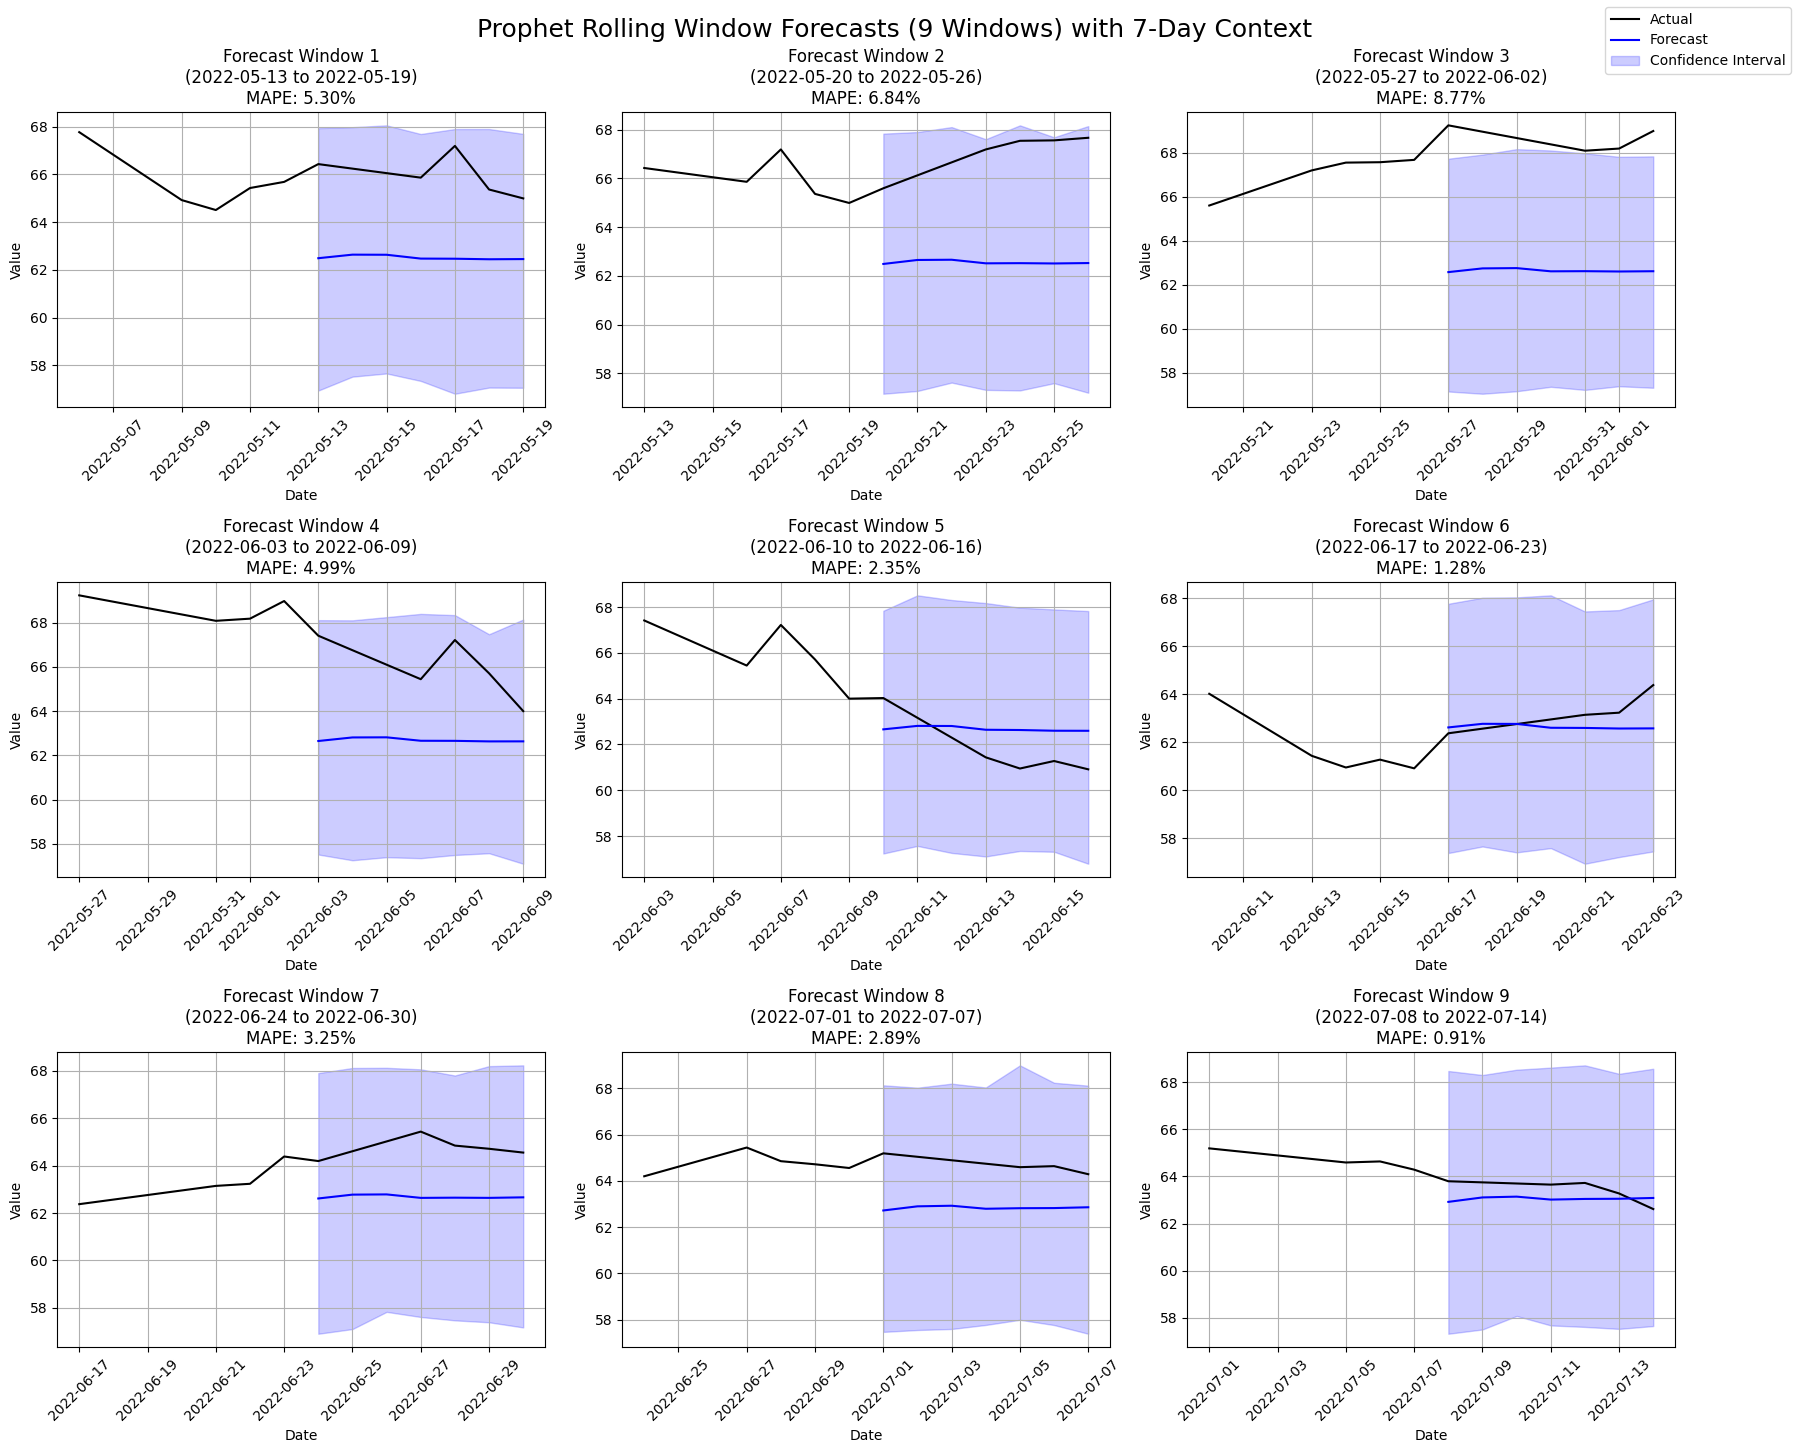


MAPE for each weekly prediction window:
[np.float64(5.297336759002482), np.float64(6.843192739274947), np.float64(8.774368000015732), np.float64(4.986143279026684), np.float64(2.353562681979667), np.float64(1.2774761495093705), np.float64(3.2505212977360434), np.float64(2.8923372912906475), np.float64(0.9084212929013809)]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet
import numpy as np

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

num_windows = 9
predict_horizon_days = 7
start_date_first_window = pd.to_datetime('2022-05-13')

context_days_before = 7

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

mape_list = []

for i in range(num_windows):
    current_prediction_start_date = start_date_first_window + pd.Timedelta(days=i * predict_horizon_days)
    current_prediction_end_date = current_prediction_start_date + pd.Timedelta(days=predict_horizon_days - 1) # Predict up to 7 days later

    future_dates = pd.date_range(start=current_prediction_start_date, end=current_prediction_end_date, freq='D')
    future = pd.DataFrame({'ds': future_dates})

    forecast = model.predict(future)

    plot_start_date = current_prediction_start_date - pd.Timedelta(days=context_days_before)
    plot_end_date = current_prediction_end_date
    actual_values_plot = df[(df['ds'] >= plot_start_date) & (df['ds'] <= plot_end_date)].copy()

    actual_values_prediction = df[(df['ds'] >= current_prediction_start_date) & (df['ds'] <= current_prediction_end_date)].copy()


    ax = axes[i]

    if not actual_values_plot.empty:
        ax.plot(actual_values_plot['ds'], actual_values_plot['y'], 'k-', label='Actual')

        if not actual_values_prediction.empty:
            comparison_df = pd.merge(actual_values_prediction[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

            current_mape = calculate_mape(comparison_df['y'], comparison_df['yhat'])

            mape_list.append(current_mape)

            ax.set_title(f'Forecast Window {i+1}\n({current_prediction_start_date.date()} to {current_prediction_end_date.date()})\nMAPE: {current_mape:.2f}%')

        else:
            mape_list.append(np.nan)
            ax.set_title(f'Forecast Window {i+1}\n({current_prediction_start_date.date()} to {current_prediction_end_date.date()})\nNo Actual Data for MAPE')

    else:
        mape_list.append(np.nan)
        ax.set_title(f'Forecast Window {i+1}\n({current_prediction_start_date.date()} to {current_prediction_end_date.date()})\nNo Actual Data to Plot')


    ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')

    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                    color='blue', alpha=0.2, label='Confidence Interval')


    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

    ax.tick_params(axis='x', rotation=45)


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')


plt.tight_layout(rect=[0, 0.03, 0.95, 0.98])
plt.suptitle('Prophet Rolling Window Forecasts (9 Windows) with 7-Day Context', fontsize=18, y=0.99)
plt.show()

print("\nMAPE for each weekly prediction window:")
print(mape_list)

In [ ]:
print(f"Average MAPE though 9 windows: {np.mean(mape_list)}")

Average MAPE though 9 windows: 4.064817721192995


In [ ]:
model_file_path = 'best_prophet_model_callback.pkl'

loaded_model  = joblib.load(model_file_path)
best_params = {
    'changepoint_prior_scale': loaded_model.changepoint_prior_scale,
    'seasonality_prior_scale': loaded_model.seasonality_prior_scale,
    'holidays_prior_scale': loaded_model.holidays_prior_scale,
    'seasonality_mode': loaded_model.seasonality_mode,
    'growth': loaded_model.growth
}

print("Using best hyperparameters:")
print(best_params)

Using best hyperparameters:
{'changepoint_prior_scale': 0.03866887327916687, 'seasonality_prior_scale': 6.4482087951689255, 'holidays_prior_scale': 2.229587419867414, 'seasonality_mode': 'additive', 'growth': 'linear'}


In [ ]:
test_start_date = pd.to_datetime('2022-04-01')
train_data = df[df['ds'] < test_start_date].copy()
test_data = df[df['ds'] >= test_start_date].copy()

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Test set starts on: {test_data['ds'].min().date()}")

Training data shape: (7212, 2)
Testing data shape: (797, 2)
Test set starts on: 2022-04-01


In [ ]:
model_on_train = Prophet(**best_params)
model_on_train.fit(train_data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/3m1t0is9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4sjnqf7g/oxhpop43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16121', 'data', 'file=/tmp/tmp4sjnqf7g/3m1t0is9.json', 'init=/tmp/tmp4sjnqf7g/oxhpop43.json', 'output', 'file=/tmp/tmp4sjnqf7g/prophet_modelrgx14ub4/prophet_model-20250606103830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:38:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Full test set forecast generated.


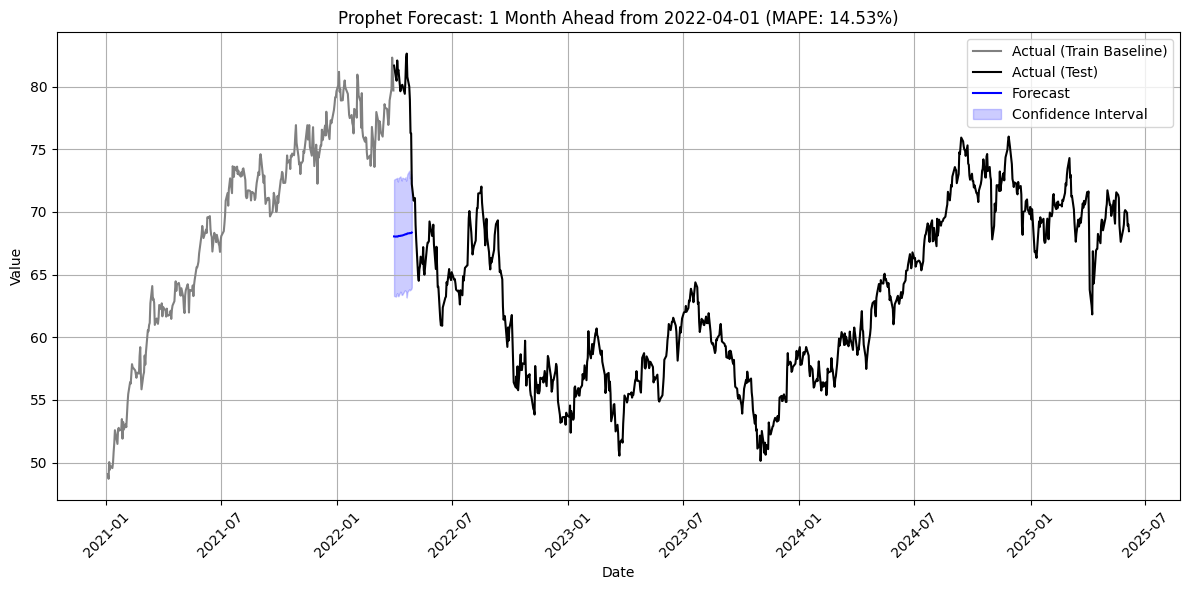

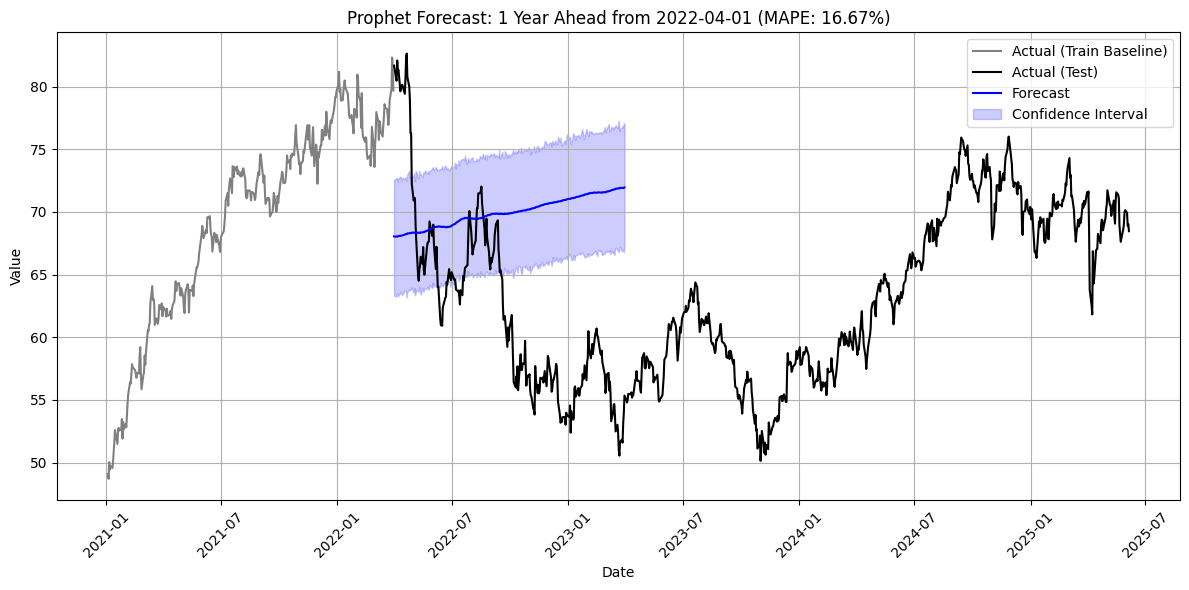

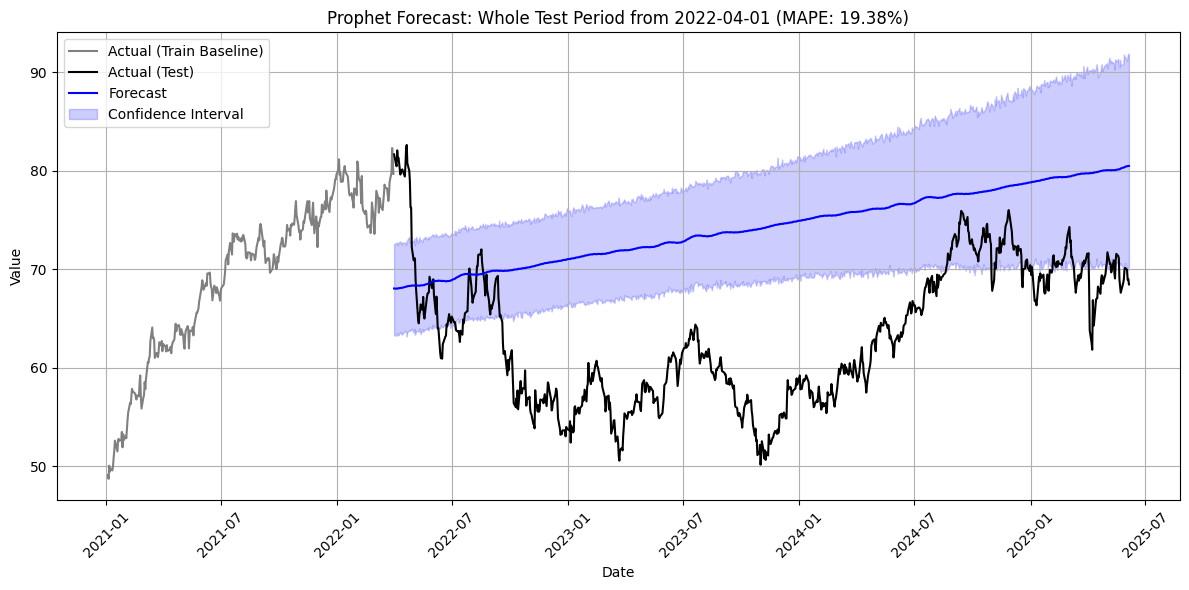

In [ ]:
future_test = test_data[['ds']].copy()
forecast_test = model_on_train.predict(future_test)

print("Full test set forecast generated.")


baseline_start_date = pd.to_datetime('2021-01-01')

train_baseline_data = train_data[train_data['ds'] >= baseline_start_date].copy()

test_baseline_data = test_data.copy()

test_start_date = test_data['ds'].min()
forecast_horizons = {
    '1 Month Ahead': test_start_date + pd.DateOffset(months=1),
    '1 Year Ahead': test_start_date + pd.DateOffset(years=1),
    'Whole Test Period': test_data['ds'].max()
}

for horizon_name, horizon_end_date in forecast_horizons.items():

    current_forecast = forecast_test[forecast_test['ds'] <= horizon_end_date].copy()
    current_test_data = test_data[test_data['ds'] <= horizon_end_date].copy()

    if not current_test_data.empty and not current_forecast.empty:
        comparison_df_horizon = pd.merge(current_test_data[['ds', 'y']], current_forecast[['ds', 'yhat']], on='ds', how='inner')
        current_mape = calculate_mape(comparison_df_horizon['y'], comparison_df_horizon['yhat'])
        mape_title_part = f" (MAPE: {current_mape:.2f}%)" if not np.isnan(current_mape) else " (MAPE: N/A)"
    else:
        current_mape = np.nan
        mape_title_part = " (MAPE: N/A - No data in horizon)"


    plt.figure(figsize=(12, 6))

    if not train_baseline_data.empty:
        plt.plot(train_baseline_data['ds'], train_baseline_data['y'], label='Actual (Train Baseline)', color='gray')

    if not test_baseline_data.empty:
        plt.plot(test_baseline_data['ds'], test_baseline_data['y'], label='Actual (Test)', color='black')

    if not current_forecast.empty:
         plt.plot(current_forecast['ds'], current_forecast['yhat'], label='Forecast', color='blue')

    if not current_forecast.empty:
        plt.fill_between(current_forecast['ds'], current_forecast['yhat_lower'], current_forecast['yhat_upper'],
                         color='blue', alpha=0.2, label='Confidence Interval')

    plt.title(f'Prophet Forecast: {horizon_name} from {test_start_date.date()}{mape_title_part}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()